# Preprocessing

#### Imports

In [12]:
import mlcroissant as mlc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
import tldextract
import Levenshtein

# logistic regression from sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)

# svm and decision tree from sklearn
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import math

#### Load Data

In [3]:
# Fetch the Croissant JSON-LD
croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/naveenbhadouria/malicious/croissant/download')

# Check what record sets are in the dataset
record_sets = croissant_dataset.metadata.record_sets
print(record_sets)

# Fetch the records and put them in a DataFrame
record_set_df = pd.DataFrame(croissant_dataset.records(record_set=record_sets[0].uuid))
df = record_set_df

  -  [Metadata(Malicious_URL's_Dataset)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.


[RecordSet(uuid="malicious_phish1.csv")]


#### Data Cleaning

In [4]:
# rename columns
df = df.rename(columns={'malicious_phish1.csv/url' : 'url', 'malicious_phish1.csv/type' : 'type'})

# Use errors='replace' to substitute bad bytes with a placeholder
df['url'] = df['url'].apply(lambda x: x.decode('utf-8', errors='replace') if isinstance(x, bytes) else x)
df['type'] = df['type'].apply(lambda x: x.decode('utf-8', errors='replace') if isinstance(x, bytes) else x)
# df.head()

In [5]:
df['malicious'] = (df['type'] != 'benign').astype(int)
# pd.set_option('display.max_colwidth', None)
# df.head(20)

#### Dataset Visualization 

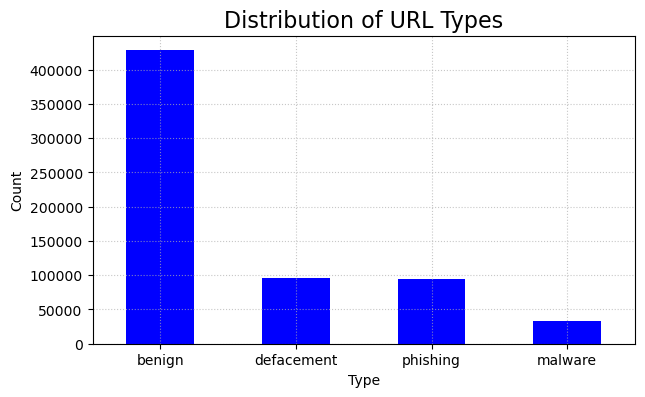

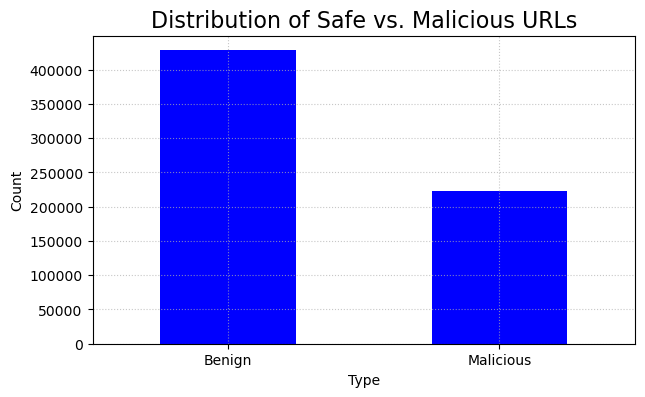

In [8]:
df['type'].value_counts().plot(kind='bar', figsize=(7, 4), color='blue')

# Add title and labels
plt.title('Distribution of URL Types', fontsize=16)
plt.xlabel('Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=0) # Keeps the x-axis labels horizontal
plt.show()

label_map = {0: 'Benign', 1: 'Malicious'}

df['malicious'].map(label_map).value_counts().plot(
    kind='bar', 
    figsize=(7, 4), 
    color='blue'
)

plt.title('Distribution of Safe vs. Malicious URLs', fontsize=16)
plt.xlabel('Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=0)
plt.show()


# Feature Engineering

#### Length Based Features 

In [6]:
# Length of URL
df['url_length'] = df['url'].str.len()
# df.head()

#### Count Based Features

In [7]:
# Number of digits
df['num_digits'] = df['url'].str.count(r'\d')

# Number of periods
df['num_periods'] = df['url'].str.count(r'\.')

# Number of slashes
df['num_slashes'] = df['url'].str.count(r'\/')

# Number of @ symbols
df['num_ats'] = df['url'].str.count(r'\@')
# df.head()

#### Binary Features

In [8]:
# Functions for advanced features

# Extract domain name (google.com, amazon.com, etc.)
def extract_domain(url):
    extracted = tldextract.extract(url)
    return extracted.domain

df['domain'] = df['url'].apply(extract_domain)


# List of brands
brands = ['google', 'paypal', 'microsoft', 'apple', 'amazon', 'netflix', 'facebook']

# Typosquat
def get_typosquat_feature(url_domain):
    min_dist = 100 

    clean_domain = url_domain.lower()
    
    for brand in brands:
        dist = Levenshtein.distance(clean_domain, brand)
        if dist < min_dist:
            min_dist = dist
            
    return min_dist

df['min_brand_dist'] = df['domain'].apply(get_typosquat_feature)

# Flag domains that are close to a brand name but not exact
def categorize_typosquat(dist):
    # if dist = 0 its the real brand
    if dist == 0:
        return 0 
    # flag if its close to the brand name but not exact (go0gle has dist 1)
    elif 0 < dist <= 2:
        return 1 
    # ignore if not close at all
    else:
        return 0 

df['is_typosquat'] = df['min_brand_dist'].apply(categorize_typosquat)


In [9]:
# Ensure URL column is string
df['url'] = df['url'].astype(str)

# Has ".htm" or ".html"
df['has_html'] = df['url'].str.contains(r'\.html?', case=False, na=False).astype(int)

# Has literal "?query="
df['has_query_param'] = df['url'].str.contains(r'\?query=', case=False, na=False).astype(int)

# Has "https://"
df['has_https'] = df['url'].str.contains(r'^https://', case=False, na=False).astype(int)

# Has "http://" (less secure)
df['has_http'] = df['url'].str.contains(r'^http://', case=False, na=False).astype(int)

# Has IPv4 address in the host part (after ://)
df['has_ip_address'] = df['url'].str.contains(r'://(?:\d{1,3}\.){3}\d{1,3}', case=False, na=False).astype(int)

# Suspicious keywords anywhere in URL
suspicious_kw = {'login', 'secure', 'payment', 'verify'}
pattern = '(' + '|'.join(suspicious_kw) + ')'
df['has_suspicious_kw'] = df['url'].str.contains(pattern, case=False, na=False).astype(int)

# Brand keywords
df['has_brand_kw'] = df['url'].str.contains(r'(google|paypal|microsoft)', case=False, na=False).astype(int)

# Has non ascii characters - mixed scripts
df['has_non_ascii_chars'] = df['url'].str.contains(r'[^\x00-\x7F]', regex=True).astype(int)

# df.head(50)


/var/folders/z0/vb2s3c210wddnfxgxfh_yy080000gn/T/ipykernel_17990/3500946682.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_suspicious_kw'] = df['url'].str.contains(pattern, case=False, na=False).astype(int)
/var/folders/z0/vb2s3c210wddnfxgxfh_yy080000gn/T/ipykernel_17990/3500946682.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_brand_kw'] = df['url'].str.contains(r'(google|paypal|microsoft)', case=False, na=False).astype(int)


# Model Training and Results

#### Logistic Regression (K-fold)

In [10]:
'''Setup'''
log_reg = LogisticRegression(max_iter=1000)     #maximum number of iterations for optimization.

# Setup X and y and scale X
y = df['malicious']
X = df.drop(['url', 'malicious', 'type', 'domain', 'users'], axis=1, errors='ignore')
df['users'] = X.index  # mirror X's index for LOOU splits

# scale X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# create kf as a K-Fold cross validator and relevant indicies cv_split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_split = kf.split(X_scaled)

# fit the logistic regression model log_reg to the split X and y training sets and make prediction
log_reg = LogisticRegression(max_iter=1000) 
log_reg.fit(X_scaled,y)
y_pred_k = cross_val_predict(log_reg, X_scaled, y, cv=cv_split)

# score evaluation
print("Accuracy:", accuracy_score(y, y_pred_k))
print("Precision:", precision_score(y, y_pred_k))
print("Recall:", recall_score(y, y_pred_k))
print("F1:", f1_score(y, y_pred_k))

Accuracy: 0.8449732874072277
Precision: 0.8545682567699382
Recall: 0.659757584450979
F1: 0.7446321967014065


#### Logistic Regression (Train-Test Split)

In [12]:
# can use the same X_scaled and y from the k-fold cv

# split into 80/20 train to test split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = .2, random_state = 42)

# fit the logistic regression model log_reg to the split X and y training sets and make prediction
log_reg.fit(X_train,y_train)
y_pred_tt = log_reg.predict(X_test)

# score evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_tt))
print("Precision:", precision_score(y_test, y_pred_tt))
print("Recall:", recall_score(y_test, y_pred_tt))
print("F1:", f1_score(y_test, y_pred_tt))

Accuracy: 0.845138552968005
Precision: 0.8523643748186829
Recall: 0.6608263421875351
F1: 0.7444730207396334


In [18]:
# # Leave-One-User-Out Cross Validation
# y_true = []
# y_pred = []

# users = df.index

# log_reg_louo = LogisticRegression(
#     max_iter=5000,
#     solver='lbfgs'  # good default for dense, relatively low-dim data
# )

# # apply louo CV by testing on left out user and 
# # training on all others for all users in the set 
# for u in users:
#     train = users != u  # training userS
#     test = users == u   # test user (left out)

#     # set training and test X and Y 
#     X_train, X_test = X[train], X[test]
#     y_train, y_test = y[train], y[test]
    
    
#     # fit model object on training data and make prediction
#     log_reg_louo.fit(X_train, y_train)       
#     pred = log_reg_louo.predict(X_test)

#     # add predictiction and corresponding actual value to arrays
#     y_true.append(y_test.values[0])     
#     y_pred.append(pred[0])

# # Evaluation
# print("Confusion Matrix:")
# print(confusion_matrix(y_true, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred))


#### Decision Tree

In [ ]:
# function to return F1, Accuracy, Precision, and Recall
# return: dict containing metrics
def metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec  = tp / (tp + fn) if (tp + fn) else 0.0
    f1   = 2*prec*rec / (prec + rec) if (prec + rec) else 0.0
    acc  = (tp + tn) / cm.sum() if cm.sum() else 0.0
    return dict(precision=prec, recall=rec, f1=f1, accuracy=acc)

# function to create the finished confusion matrix, applying leave-one-user-out cross validation (louo CV) to a support vector machine
# return: numpy array representing the final confusion matrix for given SVM parameters
def louo_cm_svm(C, kernel, gamma):
    total_cm = np.array([[0, 0], [0, 0]])   # initialize cm 

    # apply louo CV by testing on left out user and training on all others for all users in the set 
    for u in users:
        tr = users != u # training users
        te = users == u # test user (the one left out)

        # set training and test X and Y
        Xtr, Xte = X_all[tr], X_all[te]
        ytr, yte = y_all[tr], y_all[te]

        # scale sets
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)

        # create SVC object with given parameters
        clf = SVC(C=C, kernel=kernel)
        if kernel != 'linear':
            clf.set_params(gamma=gamma)   # valid for rbf only

        # fit object on training data and generate prediction
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xte)

        # add prediction to cm
        total_cm += confusion_matrix(yte, yp, labels=[0, 1])
    return total_cm

# function to create the finished confusion matrix, applying louo CV to a decision tree model
# return: numpy array representing the final confusion matrix for given decision parameters
def louo_cm_tree(max_depth, criterion, min_samples_split):
    total_cm = np.array([[0, 0], [0, 0]])   # initialize cm
    
    # apply louo CV by testing on left out user and training on all others for all users in the set 
    for u in users:
        tr = users != u # training users
        te = users == u # test user (left out)

        # set training and test X and Y
        Xtr, Xte = X_all[tr], X_all[te]
        ytr, yte = y_all[tr], y_all[te]

        # scale sets
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)

        # create DecisionTreeClassifier object from given parameters
        clf = DecisionTreeClassifier(
            max_depth=max_depth,
            criterion=criterion,
            min_samples_split=min_samples_split
        )

        # fit object on training data and generate prediction
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xte)

        # add prediction to cm
        total_cm += confusion_matrix(yte, yp, labels=[0, 1])
    return total_cm

In [ ]:
df['users'] = df.index  # Simulate user IDs

# Set X, Y, and user dataframes
X_all = df.drop(columns=['target', 'users'], errors='ignore').to_numpy()
y_all = Y = df['target'].to_numpy()
users = df['users'].to_numpy()

# Hyperparameter grids, use all possible combinations.
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

results = []

# Loop through all SVM parameters
for C in svm_params['C']:
    for kernel in svm_params['kernel']:
        gammas = [None] if kernel == 'linear' else svm_params['gamma']
        for gamma in gammas:

            cm = kf_cm_svm(C=C, kernel=kernel, gamma=gamma)
            mets = metrics_from_cm(cm)
            results.append({
                'model': 'SVM', 'C': C, 'kernel': kernel, 'gamma': gamma,
                'cm': cm, **mets
            })